In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%load_ext autoreload
%autoreload 2
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

import sys

sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from clean_helpers import *

take_full = True
test_locally = True
create_new_text_files = True

# Specify here what cleaning functions you want to use
cleaning_options = ['clean_new_line', 'remove_stopwords', 'clean_tags',
                    'clean_punctuation', 'remove_numbers']


clean = {
    "clean_new_line": clean_new_line,
    "lowercase": lowercase,
    "lemmatize": lemmatize,
    "remove_stopwords": remove_stopwords,
    "translate": perform_translation,
    "clean_punctuation": clean_punctuation,
    "clean_tags" : clean_tags,
    "remove_numbers": remove_numbers,
}


# algorithm_used = ""
# algorithm = {
#     "naive_bayes": ,
#     "logistic_regression": ,
#     "svm": ,
#     "lstm":,
#     "fasttext":,
#     "cnn": ,
# }

# options = []
# additional_options = {
#     "count_frequency": ,
#     "count_ngrams": ,
    
# }


In [8]:
input_file_pos = 'Data/train_pos.txt'
if take_full:
    input_file_pos = 'Data/train_pos_full.txt'
  
input_file_neg = 'Data/train_neg.txt'
if take_full:
    input_file_neg = 'Data/train_neg_full.txt'
    
list_of_pos_sentences = []
with open(input_file_pos, 'r') as f:
    for line in f:
        list_of_pos_sentences.append(line)
 
list_of_neg_sentences = []
with open(input_file_neg, 'r') as f:
    for line in f:
        list_of_neg_sentences.append(line)

In [9]:
from data_handling import build_sentences

df = build_sentences(list_of_pos_sentences, list_of_neg_sentences)

In [ ]:
df[df.sentence.apply(lambda x: len(x.split("\n"))) > 2].head()

In [10]:
# Perform all the cleaning options selected

for clean_option in cleaning_options:
    counter_of_occurrences = 0
    %time df = clean[clean_option](df)
    print(clean_option)
    print(df.head())
    
    print(len(df[df.sentence.apply(lambda x: x.find("  ") != -1)]))
    print(df.iloc[1].sentence)
    print("################################\n\n")
    

df.head()

CPU times: user 4.24 s, sys: 440 ms, total: 4.68 s
Wall time: 4.38 s
clean_new_line
                                            sentence  label
0  <user> i dunno justin read my mention or not ....      1
1  because your logic is so dumb , i won't even c...      1
2  " <user> just put casper in a box ! " looved t...      1
3  <user> <user> thanks sir > > don't trip lil ma...      1
4  visiting my brother tmr is the bestest birthda...      1
0
because your logic is so dumb , i won't even crop out your name or your photo . tsk . <url>
################################


CPU times: user 9.74 s, sys: 139 ms, total: 9.88 s
Wall time: 9.73 s
remove_stopwords
                                            sentence  label
0  <user> dunno justin read mention . justin god ...      1
1    logic dumb , even crop name photo . tsk . <url>      1
2  " <user> put casper box ! " looved battle ! #c...      1
3  <user> <user> thanks sir > > trip lil mama ......      1
4  visiting brother tmr bestest birthday 

,sentence,label
0,dunno justin read mention justin god knows hop...,1
1,logic dumb even crop name photo tsk,1
2,put casper box ! looved battle ! #crakkbitch,1
3,thanks sir trip lil mama .. keep doin ya thang !,1
4,visiting brother tmr bestest birthday gift eve...,1


In [11]:
# Print counter of sentence per each label
print(df.count())
print(df[df.label == -1].count())
print(df[df.label ==  1].count())

sentence    2500000
label       2500000
dtype: int64
sentence    1250000
label       1250000
dtype: int64
sentence    1250000
label       1250000
dtype: int64


In [12]:
from helpers import count_unique_words, count_unique_ngrams

count_unique_words(df)

573316

In [13]:
from helpers import count_unique_words

count_unique_ngrams(df, 3)

10949107

In [15]:
import fasttext    # library to do sentence representation
from helpers import create_labelled_file
k_folds = 5

In [18]:
%%time
if create_new_text_files:
    # create k-fold
    kf = KFold(n_splits=k_folds, shuffle=True)
    iter_n = 0
    for train_index, test_index in tqdm(kf.split(df)):
        # create test and train for the k-fold cross validation
        train = df.iloc[train_index]
        test = df.iloc[test_index]
        train_file = create_labelled_file("cross_val/train_fasttext_{}.txt".format(iter_n), train)
        test_file = create_labelled_file("cross_val/test_fasttext_{}.txt".format(iter_n), test)
        iter_n += 1


CPU times: user 20min 34s, sys: 1.85 s, total: 20min 35s
Wall time: 20min 36s


In [21]:
if test_locally is True:
    df_precisions = {}
    for epochs in tqdm(range(1, 10, 2)):
        precisions = []
        for k in range(k_folds):
            model = fasttext.train_supervised("cross_val/train_fasttext_{}.txt".format(k), epoch=epochs)
            results = model.test("cross_val/test_fasttext_{}.txt".format(k))
            precisions.append(results[1])   # results is a tuple with number of predictions, precision and recall
            # in our case both the precision and the recall are the same (there is only one possible label)
        df_precisions[epochs] = precisions
        print(np.array(precisions).mean())

0.7802268
0.7925516000000001
0.6203488
0.7348451999999999
0.7955371999999998



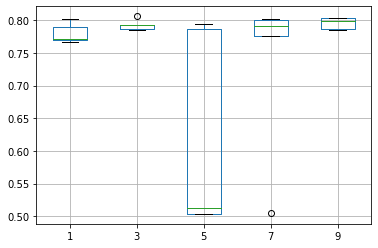

In [22]:
df_precisions = pd.DataFrame(df_precisions)
df_precisions.boxplot()

In [ ]:
# Shuffle rows, and create train and test set
shuffled = df.sample(frac=1)
train = shuffled[:int(len(df) * 0.7)]
test = shuffled[int(len(df) * 0.7) + 1: ]

%time model = fasttext.train_supervised('train_fasttext.txt')

In [ ]:
model.test("test_fasttext.txt")

In [ ]:
output_file = "output/output.csv"
if not test_locally:
    write(y_pred, output_file)

In [ ]:
df = []
with open("Data/test_data.txt", 'r') as f:
    for l in f:
        id_ = l.split(",")[0]
        sentence = ",".join(l.split(",")[1:])
        df.append({
            "id": int(id_),
            "sentence": sentence
        })
df = pd.DataFrame(df)
df.head()